# Uber project (unsupervised Learning)

Uber already has data about pickups in major cities. Your objective is to create algorithms that will determine where are the hot-zones that drivers should be in. Purposes:

- Create an algorithm to find hot zones
- Visualize results on a nice dashboard

**** IDEAS ****
- algorithm : make iterations on "eps" and "min_samples" to find, for each case, the best ratio
- EDA : observe where we get variations
- visualization : subplots with day of week, hour, etc.

<b>Deliverable 📬</b>

To complete this project, your team should:

- Have a map with hot-zones using any python library (plotly or anything else).
- You should at least describe hot-zones per day of week.
- Compare results with at least two unsupervised algorithms like KMeans and DBScan.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.io as pio
import plotly.express as px
pio.renderers.default = "iframe_connected"

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN

## First look on April 2014 only

We first try on a smaller dataset : April 2014 alone. We will try to find some patterns and apply ML models, and then we will add the other months in order to check if observations generalize.

### EDA

In [2]:
df_apr_14 = pd.read_csv('uber-raw-data-apr14.csv')

In [3]:
df_apr_14

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764


In [4]:
df_apr_14 = df_apr_14.sample(10_000)

In [5]:
df_apr_14.Base.value_counts()

B02682    4000
B02598    3260
B02617    1956
B02512     617
B02764     167
Name: Base, dtype: int64

In [6]:
fig = px.scatter_mapbox(df_apr_14, lat="Lat", lon="Lon", mapbox_style='carto-positron')
fig.show()

In [7]:
df_apr_14['Date/Time'] = pd.to_datetime(df_apr_14['Date/Time'])

In [8]:
df_apr_14['dayofweek'] = df_apr_14['Date/Time'].dt.dayofweek

In [9]:
df_apr_14

,Date/Time,Lat,Lon,Base,dayofweek
473642,2014-04-20 20:10:00,40.7947,-73.9323,B02682,6
109267,2014-04-15 16:02:00,40.7522,-73.9914,B02598,1
237669,2014-04-05 19:15:00,40.7249,-74.0028,B02617,5
99015,2014-04-13 00:15:00,40.7281,-74.0055,B02598,6
487876,2014-04-23 09:12:00,40.7177,-73.7764,B02682,2
...,...,...,...,...,...
65245,2014-04-06 19:49:00,40.6941,-73.9919,B02598,6
113481,2014-04-16 07:08:00,40.7314,-73.9750,B02598,2
116493,2014-04-16 17:53:00,40.7488,-73.9843,B02598,2
115727,2014-04-16 16:13:00,40.7503,-74.0061,B02598,2


Later, we will observe the points repartition depending on the day of week. We drop 'Date/Time' and 'Base' columns :

In [10]:
df_apr_14 = df_apr_14[['Lat', 'Lon', 'dayofweek']]

In [11]:
df_apr_14.isna().sum()

Lat          0
Lon          0
dayofweek    0
dtype: int64

We don't have any Na in the dataset.

In [12]:
df_apr_14.head()

,Lat,Lon,dayofweek
473642,40.7947,-73.9323,6
109267,40.7522,-73.9914,1
237669,40.7249,-74.0028,5
99015,40.7281,-74.0055,6
487876,40.7177,-73.7764,2


### A try with Kmeans

In [13]:
numeric_scaler = StandardScaler()

In [14]:
X = numeric_scaler.fit_transform(df_apr_14[['Lat', 'Lon']])

In [15]:
X[:7]

array([[ 1.55161407,  0.88404626],
       [ 0.35414163, -0.29325286],
       [-0.41505832, -0.52034609],
       [-0.32489569, -0.57413133],
       [-0.61792424,  3.98964579],
       [ 1.28957892,  0.14898133],
       [ 0.25834383, -0.53229837]])

In [16]:
kmeans = KMeans(6, random_state=0)
kmeans.fit(X)
predictions = kmeans.predict(X)
df_apr_14['predictions'] = predictions.copy()
df_apr_14.head()

C:\Users\Bastien\AppData\Local\Temp/ipykernel_1204/899639310.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Lat,Lon,dayofweek,predictions
473642,40.7947,-73.9323,6,3
109267,40.7522,-73.9914,1,0
237669,40.7249,-74.0028,5,4
99015,40.7281,-74.0055,6,4
487876,40.7177,-73.7764,2,2


In [17]:
df_apr_14['predictions'].value_counts()

4    4455
0    3955
1     895
3     366
2     262
5      67
Name: predictions, dtype: int64

In [18]:
fig = px.scatter_mapbox(df_apr_14, lat="Lat", lon="Lon", color="predictions", mapbox_style='carto-positron')
fig.show()

Kmeans is usefull to make a separation but it does not inform about the density of requests : it will not help us identify zones with lots of requests, and eventualy we could get to a situation where we do not have enough drivers in hot areas.

For example, we can see that cluster representing the North of Brooklyn seems dense in some sub-areas and very sparse in others : this cluster does not provide much information as it is.

We will use DBSCAN to find the hot zones.

### More EDA

We charge the whole dataset again :

In [19]:
df_apr_14 = pd.read_csv('uber-raw-data-apr14.csv')
df_apr_14['Date/Time'] = pd.to_datetime(df_apr_14['Date/Time'])
df_apr_14.head(5)

,Date/Time,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


We want to look at the repartition of Uber requests depending on hour of the day, in order to identify the most crucial timings :

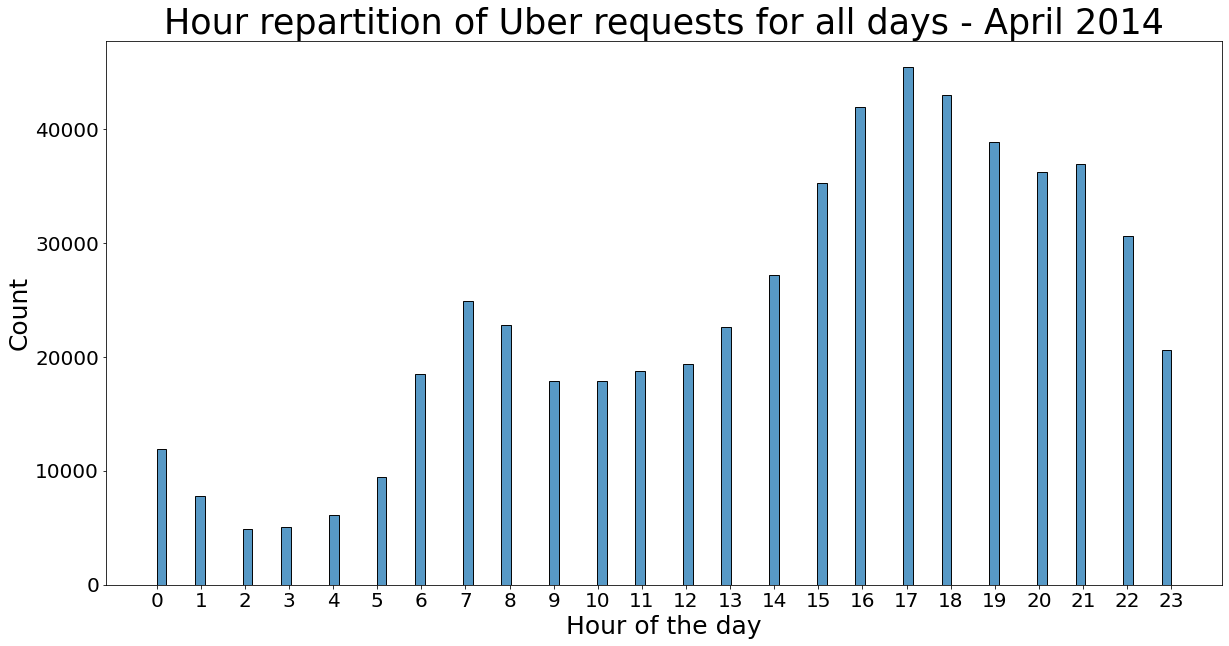

In [20]:

df_apr_14['hour'] = df_apr_14['Date/Time'].dt.hour


fig = plt.figure(1, figsize=(20, 10))

sns.histplot(data = df_apr_14, x = 'hour' )

plt.title('Hour repartition of Uber requests for all days - April 2014', fontsize = 35)
plt.xlabel('Hour of the day', fontdict={'size' : 25})
plt.xticks([x for x in range(24)], fontsize = 20)
plt.ylabel('Count', fontdict={'size' : 25})
plt.yticks(fontsize = 20)

plt.show()

We observe (on April 2014 dataset) :
- fewer demand before 5 am
- an increase in requests starting around 5 am and then stagning from 9 to 12
- a new increase until 17
- a global decrease until the end of the day

Before going further, let's see if we have a different behaviour for the different days of the week :

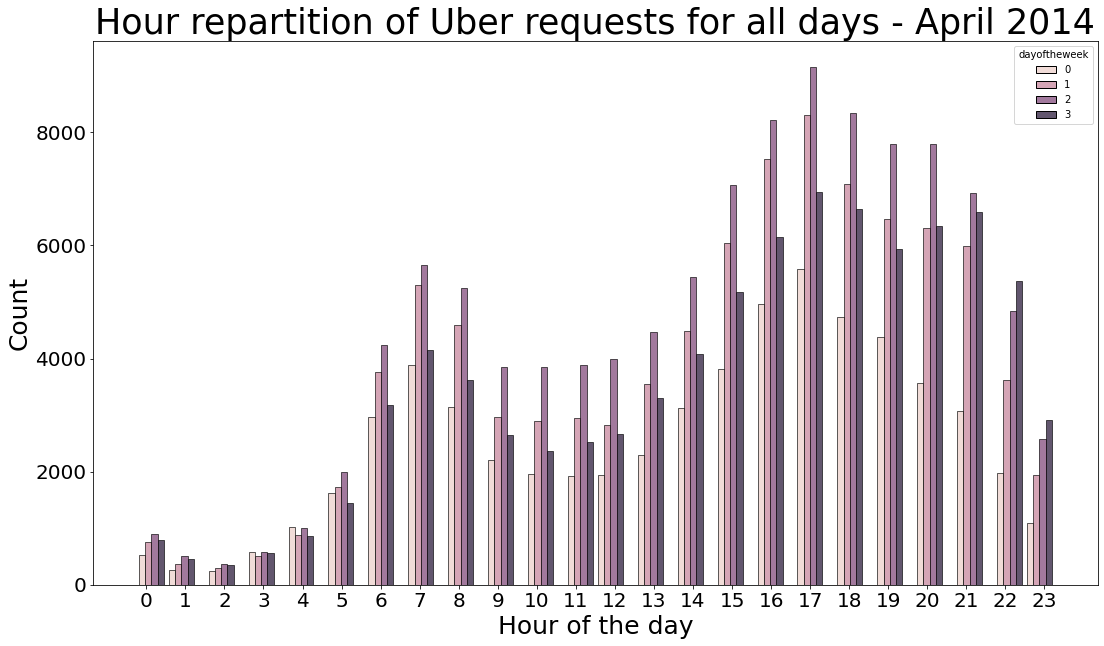

In [21]:

df_apr_14['dayoftheweek'] = df_apr_14['Date/Time'].dt.dayofweek


fig = plt.figure(1, figsize=(18, 10))

sns.histplot(data = df_apr_14[df_apr_14['dayoftheweek']<4], x = 'hour', hue = 'dayoftheweek' , multiple="dodge",  shrink=2.5)

plt.title('Hour repartition of Uber requests for all days - April 2014', fontsize = 35)
plt.xlabel('Hour of the day', fontdict={'size' : 25})
plt.xticks([x for x in range(24)], fontsize = 20)
plt.ylabel('Count', fontdict={'size' : 25})
plt.yticks(fontsize = 20)

plt.show()

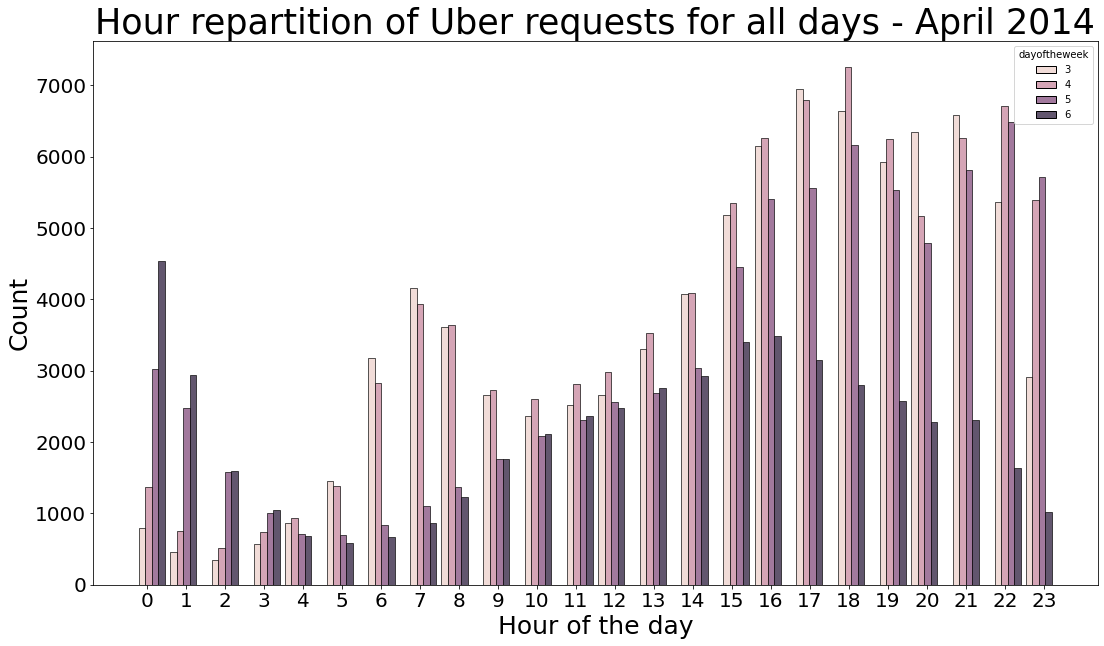

In [22]:

df_apr_14['dayoftheweek'] = df_apr_14['Date/Time'].dt.dayofweek


fig = plt.figure(1, figsize=(18, 10))

sns.histplot(data = df_apr_14[(df_apr_14['dayoftheweek']<10) & (df_apr_14['dayoftheweek']>2)], x = 'hour', hue = 'dayoftheweek' , multiple="dodge",  shrink=2.5)

plt.title('Hour repartition of Uber requests for all days - April 2014', fontsize = 35)
plt.xlabel('Hour of the day', fontdict={'size' : 25})
plt.xticks([x for x in range(24)], fontsize = 20)
plt.ylabel('Count', fontdict={'size' : 25})
plt.yticks(fontsize = 20)

plt.show()

In [23]:
df_grouped = df_apr_14.groupby(['dayoftheweek', 'hour']).count().reset_index()[['dayoftheweek', 'hour', 'Lat']].rename(columns = {'Lat' : 'count'})
df_grouped

,dayoftheweek,hour,count
0,0,0,518
1,0,1,261
2,0,2,238
3,0,3,571
4,0,4,1021
...,...,...,...
163,6,19,2579
164,6,20,2276
165,6,21,2310
166,6,22,1639


In [24]:
total_counts_per_day = []

for i in range(7):
    total_counts_per_day.append(df_grouped[df_grouped['dayoftheweek'] == i]['count'].sum())

df_grouped['total_appearance_by_day'] = df_grouped['dayoftheweek'].apply(lambda x : total_counts_per_day[x])
df_grouped['frequency_appearance_by_day'] = df_grouped['count'] / df_grouped['total_appearance_by_day']
df_grouped.head(10)

,dayoftheweek,hour,count,total_appearance_by_day,frequency_appearance_by_day
0,0,0,518,60861,0.008511
1,0,1,261,60861,0.004288
2,0,2,238,60861,0.003911
3,0,3,571,60861,0.009382
4,0,4,1021,60861,0.016776
5,0,5,1619,60861,0.026602
6,0,6,2974,60861,0.048865
7,0,7,3888,60861,0.063883
8,0,8,3138,60861,0.051560
9,0,9,2211,60861,0.036329


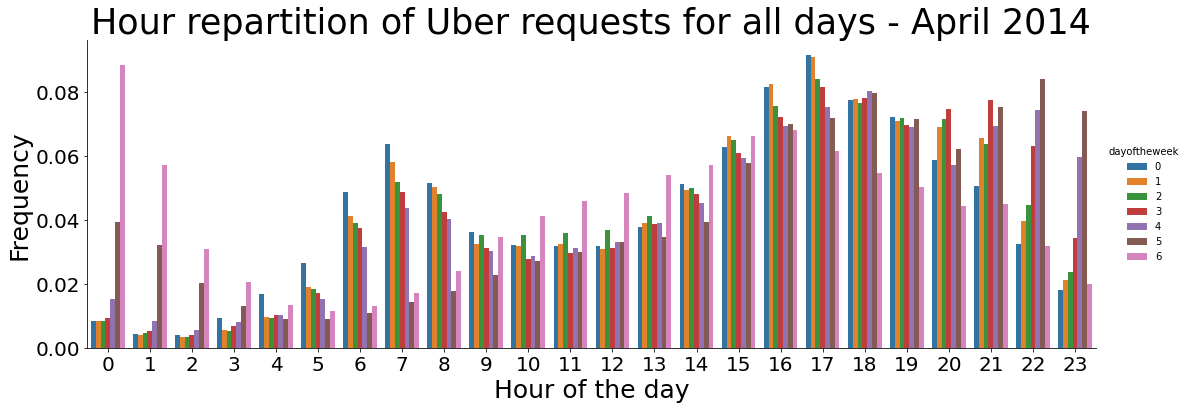

In [25]:

sns.catplot(data = df_grouped, x = 'hour', y = 'frequency_appearance_by_day', hue = 'dayoftheweek' , kind = 'bar', aspect = 3)

plt.title('Hour repartition of Uber requests for all days - April 2014', fontsize = 35)
plt.xlabel('Hour of the day', fontdict={'size' : 25})
plt.xticks([x for x in range(24)], fontsize = 20)
plt.ylabel('Frequency', fontdict={'size' : 25})
plt.yticks(fontsize = 20)

plt.show()

<b>Observations :</b>
- from 0 am to 2 am : most of the days have few proportion in this time slot, except for Saturdays and Sundays which have an important proportion here (due obviously to people who go out later on weekends)
- from 3 to 5 am : no much to say, proportion is low for every day of the week
- from 6 to 8 am : requests are important in working days but much lower in Saturdays and Sundays
- from 9 am to 4 pm : the repartition is the same for all days of week
- from 5 to 8 pm : all days are almost equals, except for Sundays which are lower
- end of the day (10, 11 pm) : mostly Fridays and Saturdays. Thursday is also present at 22 !

We observed the data relatively for each day of the week in order to see trends for a given day of the week :
for example, if a Uber driver wants to work on a saturday, he might except more customers at 5pm than 7am.

But we would also like to compare the days one to another. We would like to answer the question : is it better to work on a sunday or a monday ?

For this purpose we must do another visualization :

In [26]:
df_apr_14['date'] = df_apr_14['Date/Time'].dt.date

In [27]:
df_dates = pd.DataFrame(df_apr_14['date'].unique())
df_dates['dayofweek'] = pd.to_datetime(df_dates[0]).dt.dayofweek
df_dates['dayofweek'].value_counts()

1    5
2    5
3    4
4    4
5    4
6    4
0    4
Name: dayofweek, dtype: int64

We have (in April dataset) :
- 5 appearances of Tuesday and Wednesday
- 4 appearances of all the other days of the week

Let us make a new column in our 'grouped' dataset by dividing the number of requests for each day by the number of appearances of each day of the week :

In [28]:
nb_days_appearances = []

for i in range(7) :
    nb_days_appearances.append(df_dates['dayofweek'].value_counts()[i])
    
nb_days_appearances


[4, 5, 5, 4, 4, 4, 4]

In [29]:
df_grouped.head()

,dayoftheweek,hour,count,total_appearance_by_day,frequency_appearance_by_day
0,0,0,518,60861,0.008511
1,0,1,261,60861,0.004288
2,0,2,238,60861,0.003911
3,0,3,571,60861,0.009382
4,0,4,1021,60861,0.016776


In [30]:
df_grouped['apparances_day_of_week'] = df_grouped['dayoftheweek'].apply(lambda x : nb_days_appearances[x])
df_grouped.tail(10)

,dayoftheweek,hour,count,total_appearance_by_day,frequency_appearance_by_day,apparances_day_of_week
158,6,14,2934,51251,0.057248,4
159,6,15,3400,51251,0.066340,4
160,6,16,3489,51251,0.068077,4
161,6,17,3154,51251,0.061540,4
162,6,18,2795,51251,0.054536,4
163,6,19,2579,51251,0.050321,4
164,6,20,2276,51251,0.044409,4
165,6,21,2310,51251,0.045072,4
166,6,22,1639,51251,0.031980,4
167,6,23,1018,51251,0.019863,4


In [31]:
df_grouped['frequency_apparances_by_day_of_week'] = df_grouped['count'] / df_grouped['apparances_day_of_week'] 
df_grouped.head(10)

,dayoftheweek,hour,count,total_appearance_by_day,frequency_appearance_by_day,apparances_day_of_week,frequency_apparances_by_day_of_week
0,0,0,518,60861,0.008511,4,129.50
1,0,1,261,60861,0.004288,4,65.25
2,0,2,238,60861,0.003911,4,59.50
3,0,3,571,60861,0.009382,4,142.75
4,0,4,1021,60861,0.016776,4,255.25
5,0,5,1619,60861,0.026602,4,404.75
6,0,6,2974,60861,0.048865,4,743.50
7,0,7,3888,60861,0.063883,4,972.00
8,0,8,3138,60861,0.051560,4,784.50
9,0,9,2211,60861,0.036329,4,552.75


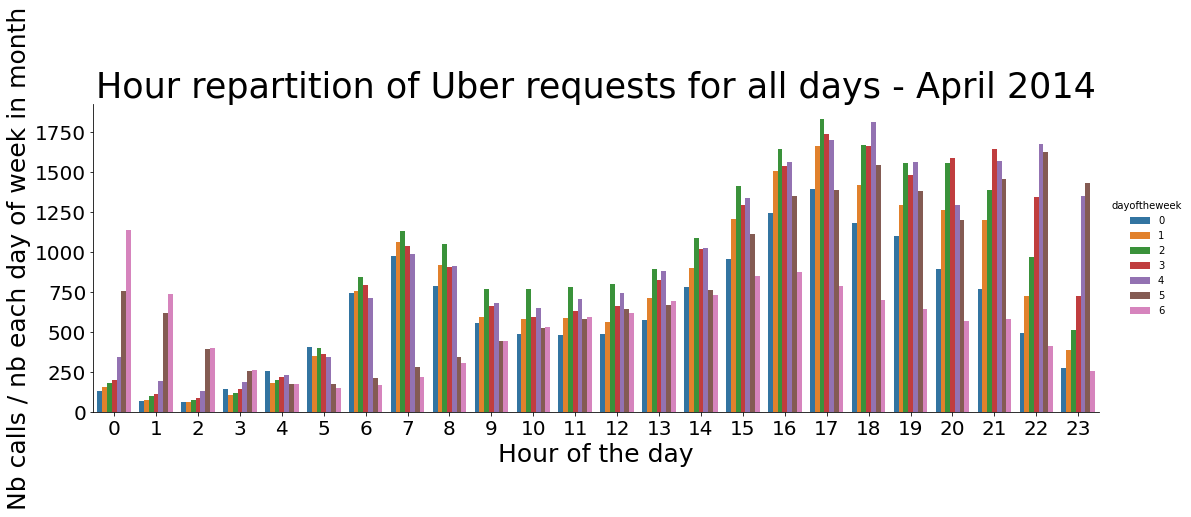

In [32]:

sns.catplot(data = df_grouped, x = 'hour', y = 'frequency_apparances_by_day_of_week', hue = 'dayoftheweek' , kind = 'bar', aspect = 3)

plt.title('Hour repartition of Uber requests for all days - April 2014', fontsize = 35)
plt.xlabel('Hour of the day', fontdict={'size' : 25})
plt.xticks([x for x in range(24)], fontsize = 20)
plt.ylabel('Nb calls / nb each day of week in month', fontdict={'size' : 25})
plt.yticks(fontsize = 20)

plt.show()

!!! this figure shows us the most valuable moments in term of hour and day of the week ! We will use it later when we perform DBscan to focus on most valuable time slots.

<AxesSubplot:xlabel='dayoftheweek'>

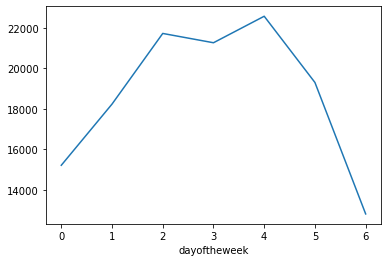

In [33]:
df_grouped.groupby('dayoftheweek').sum()['frequency_apparances_by_day_of_week'].plot()

We can conclude that the market in NYC for Uber is more important from Wednesday to Friday, average on Tuesdays and Saturdays, and low on Mondays and Sundays

### DBSCAN : Clusters research on hot times and zones

The purpose of this project is to identify moments when the demand is high in order to dimension a good amount of drivers.

Considering what we saw in the previous part, we can say that the following moments are the more crucial ones (approximately) :
- Monday to Saturday, 4pm to 7pm 
- Friday and Saturday nights, 9pm to 11pm
- Monday to Friday, 6am to 8am

We will not perform all the views here so we selected :
- Monday afternoon, 4pm to 7pm
- Friday night, 9pm to 11pm
- Friday morning, 6am to 8am


Kmeans does not suit this problem right as we saw previously : we need to cluster by density and not by borders made by "size". Also we do not know in advance what are the number of clusters we want.

That's why we will use Dbscan in next sections.


In [34]:
df_apr_14.head()

,Date/Time,Lat,Lon,Base,hour,dayoftheweek,date
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,0,1,2014-04-01
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,0,1,2014-04-01
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,0,1,2014-04-01
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,0,1,2014-04-01
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,0,1,2014-04-01


#### Monday afternoon, 4pm to 7pm

Determine the first Monday :

In [35]:
df_apr_14['day'] = df_apr_14['Date/Time'].dt.day

In [36]:
df_apr_14[df_apr_14['dayoftheweek'] == 0]['day'].unique()

array([ 7, 14, 21, 28], dtype=int64)

-> 2014, 7th of April was the first Monday of this month. Let's focus on this :

In [37]:
df_apr_14_first_monday = df_apr_14[df_apr_14['day'] == 7]

In [38]:
df_apr_14_first_monday.shape

(19550, 8)

Now we want to take a look at the late afternoon part :

In [39]:
df_apr_14_first_monday_evening = df_apr_14_first_monday[df_apr_14_first_monday['hour'].isin([16, 17, 18, 19])]

In [40]:
df_apr_14_first_monday_evening.describe()

,Lat,Lon,hour,dayoftheweek,day
count,8119.000000,8119.000000,8119.000000,8119.0,8119.0
mean,40.743375,-73.980612,17.548220,0.0,7.0
std,0.028555,0.038274,1.087051,0.0,0.0
min,40.439900,-74.656100,16.000000,0.0,7.0
25%,40.727400,-73.997150,17.000000,0.0,7.0
50%,40.749300,-73.984100,18.000000,0.0,7.0
75%,40.759700,-73.973800,19.000000,0.0,7.0
max,41.059700,-73.495000,19.000000,0.0,7.0


In [41]:
# Now let's just keep the columns we need for dbscan (lat and lon) :
df_apr_14_first_monday_evening = df_apr_14_first_monday_evening[['Lat', 'Lon']]


In [42]:
df_apr_14_first_monday_evening.head()

,Lat,Lon
8336,40.7261,-73.9918
8337,40.8308,-73.9202
8338,40.7404,-74.0058
8339,40.6902,-73.9814
8340,40.7616,-73.9679


In [43]:
df_apr_14_first_monday_evening

,Lat,Lon
8336,40.7261,-73.9918
8337,40.8308,-73.9202
8338,40.7404,-74.0058
8339,40.6902,-73.9814
8340,40.7616,-73.9679
...,...,...
556974,40.7191,-74.0016
556975,40.7460,-74.0016
556976,40.7579,-73.9820
556977,40.7583,-73.9671


In [44]:
# finally ! we apply dbscan now and visualize the map.
# we performed the iterations manually to find interesting hyperparameters eps and min_samples
# hyperparameter 'metric' has been set to 'manhattan' in order to be closer to a driver traject

from sklearn.cluster import DBSCAN 

dbscan = DBSCAN(n_jobs=-1, eps = 0.008, min_samples = 22, metric = 'manhattan')

X = df_apr_14_first_monday_evening.copy()
X['predictions'] = dbscan.fit_predict(X)
fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color="predictions", mapbox_style='carto-positron')
fig.show()

Let's describe what we see !
- island of Manhattan (from south to north of Central park) is the most dense area. this whole zone is in one single cluster
- we then have three little clusters in Brooklyn along the East River
- there is another cluster in airports (JFK in South East and LaGuardia North of Queens)

The other points are outliers, those zones are the ones we should focus most of our drivers on. However, if the purpose of Uber is to avoid customers to wait more than 5 minutes, we should not forget the outlier either, this map is just a way to point out the most critical zones in a given time.

#### Friday night, 9pm to 11pm

In [45]:
df_apr_14[df_apr_14['dayoftheweek'] == 4]['day'].unique()

array([ 4, 11, 18, 25], dtype=int64)

-> 2014, 4th of April was the first Friday of this month.

In [46]:
df_apr_14_first_friday = df_apr_14[df_apr_14['day'] == 4]
df_apr_14_first_friday_night = df_apr_14_first_friday[df_apr_14_first_friday['hour'].isin([21, 22, 23])]
df_apr_14_first_friday_night = df_apr_14_first_friday_night[['Lat', 'Lon']]

In [47]:
dbscan = DBSCAN(n_jobs=-1, eps = 0.008, min_samples = 22, metric = 'manhattan')

X = df_apr_14_first_friday_night.copy()
X['predictions'] = dbscan.fit_predict(X)
fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color="predictions", mapbox_style='carto-positron')
fig.show()

Almost the same results. We used the same hyperparameters as before on Monday afternoon.

We see we have more density globally, maybe because of both people leaving work late and people going out in the same time ...

We also see a little cluster in Hoboken, maybe people calling Uber to join New York for the night.

#### Friday morning, 6am to 8am

In [48]:
df_apr_14_first_friday_morning = df_apr_14_first_friday[df_apr_14_first_friday['hour'].isin([6, 7, 8])]
df_apr_14_first_friday_morning = df_apr_14_first_friday_morning[['Lat', 'Lon']]

In [49]:
dbscan = DBSCAN(n_jobs=-1, eps = 0.0089, min_samples = 20, metric = 'manhattan')

X = df_apr_14_first_friday_morning.copy()
X['predictions'] = dbscan.fit_predict(X)
fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color="predictions", mapbox_style='carto-positron')
fig.show()

Still the same zones appearing ! We see less arrivals in airports than previous daytime analysis, but generaly the Manhattan & Brooklyn parts already seen take important place here too.

## Generalization on all available months
(2014 ; April, May, June, July, August, September)

In [83]:

import glob

path = r'uber-trip-data'
all_files = glob.glob(path + "/*.csv")

list_dataframes = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_dataframes.append(df)

df_complete = pd.concat(list_dataframes, axis=0, ignore_index=True)
df_complete.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [84]:
df_complete = df_complete.drop('Base', axis = 1)

In [85]:
df_complete.head()

,Date/Time,Lat,Lon
0,4/1/2014 0:11:00,40.7690,-73.9549
1,4/1/2014 0:17:00,40.7267,-74.0345
2,4/1/2014 0:21:00,40.7316,-73.9873
3,4/1/2014 0:28:00,40.7588,-73.9776
4,4/1/2014 0:33:00,40.7594,-73.9722


In [86]:
df_complete.describe()

,Lat,Lon
count,4.534327e+06,4.534327e+06
mean,4.073926e+01,-7.397302e+01
std,3.994991e-02,5.726670e-02
min,3.965690e+01,-7.492900e+01
25%,4.072110e+01,-7.399650e+01
50%,4.074220e+01,-7.398340e+01
75%,4.076100e+01,-7.396530e+01
max,4.211660e+01,-7.206660e+01


In [72]:
print(df_complete['Lat'].isna().value_counts())

False    4534327
Name: Lat, dtype: int64


In [73]:
print(df_complete['Lon'].isna().value_counts())

False    4534327
Name: Lon, dtype: int64


In [76]:
df_complete.shape

(4534327, 2)

What to do :
- get day, month, year, hour, day of week

What to look :
- boxes grouped by day of the week





In [94]:
df_complete['Date/Time'] = pd.to_datetime(df_complete['Date/Time'])

df_complete['year'] = df_complete['Date/Time'].dt.year
df_complete['month'] = df_complete['Date/Time'].dt.month
df_complete['dayofweek'] = df_complete['Date/Time'].dt.dayofweek
df_complete['day'] = df_complete['Date/Time'].dt.day
df_complete['hour'] = df_complete['Date/Time'].dt.hour
df_complete['date'] = df_complete['Date/Time'].dt.date


In [95]:
df_complete.head()

,Date/Time,Lat,Lon,year,month,dayofweek,day,hour,date
0,2014-04-01 00:11:00,40.7690,-73.9549,2014,4,1,1,0,2014-04-01
1,2014-04-01 00:17:00,40.7267,-74.0345,2014,4,1,1,0,2014-04-01
2,2014-04-01 00:21:00,40.7316,-73.9873,2014,4,1,1,0,2014-04-01
3,2014-04-01 00:28:00,40.7588,-73.9776,2014,4,1,1,0,2014-04-01
4,2014-04-01 00:33:00,40.7594,-73.9722,2014,4,1,1,0,2014-04-01


In [112]:
df_by_date = df_complete.groupby('date').count().reset_index()[['date', 'Date/Time']]
df_by_date.rename(columns = {'Date/Time' : 'nb_calls_a_day'}, inplace = True)
df_by_date['date'] = pd.to_datetime(df_by_date['date'])

df_by_date['dayofweek'] = df_by_date['date'].dt.dayofweek

We plot boxes to observe statistics over the number of calls per day of the week :

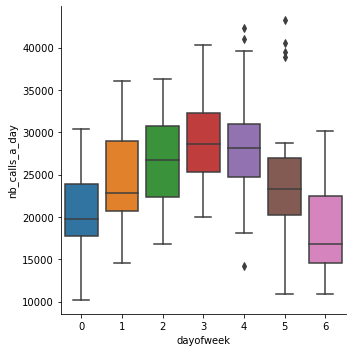

In [113]:
sns.catplot(data = df_by_date, x = 'dayofweek', y = 'nb_calls_a_day' , kind = 'box')
plt.show()

What we see here (averagely) is consistent with what we saw in first part : the usage of Uber increases from Monday to Thursday and then decreases until Sunday.

We could not observe all datas given the time we have for this project, so we will focus on two "extreme" observations : the min value on Mondays and the "outlier" max number of call on a Saturday.

### Monday minimum value

In [118]:
min_nb_calls_monday = df_by_date[df_by_date['dayofweek'] == 0]['nb_calls_a_day'].min()

In [119]:
min_nb_calls_monday

10202

It seems consistent with the graph above, let's focus on this date.

In [134]:
date_monday_min_value = df_by_date[(df_by_date['dayofweek'] == 0) & (df_by_date['nb_calls_a_day'] == min_nb_calls_monday)]['date'].iloc[0]

In [135]:
date_monday_min_value

Timestamp('2014-05-26 00:00:00')

In [140]:
df_complete['date'] = df_complete['Date/Time'].dt.date

df_monday_min_value = df_complete[df_complete['date'] == date_monday_min_value]



C:\Users\Bastien\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [144]:
df_monday_min_value = df_monday_min_value[['Lat', 'Lon']]

In [153]:
dbscan = DBSCAN(n_jobs=-1, eps = 0.006, min_samples = 30, metric = 'manhattan')

X = df_monday_min_value.copy()
X['predictions'] = dbscan.fit_predict(X)
fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color="predictions", mapbox_style='carto-positron')
fig.show()

We choose to have a global look on the whole day to simplify. We still see the same hot spots as previously.

### Saturday max value

In [163]:
#outlier saturday to show at the end

max_saturday = df_by_date[df_by_date['dayofweek'] == 5]['nb_calls_a_day'].max()
date_sat_max_value = df_by_date[(df_by_date['dayofweek'] == 5) & (df_by_date['nb_calls_a_day'] == max_saturday)]['date'].iloc[0]
df_sat_max_value = df_complete[df_complete['date'] == date_sat_max_value]
df_sat_max_value.head()



C:\Users\Bastien\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



,Date/Time,Lat,Lon,year,month,dayofweek,day,hour,date
3521953,2014-09-13 00:00:00,40.7228,-74.0045,2014,9,5,13,0,2014-09-13
3521954,2014-09-13 00:00:00,40.7618,-73.9940,2014,9,5,13,0,2014-09-13
3521955,2014-09-13 00:04:00,40.7505,-74.0031,2014,9,5,13,0,2014-09-13
3521956,2014-09-13 00:05:00,40.7418,-73.9972,2014,9,5,13,0,2014-09-13
3521957,2014-09-13 00:06:00,40.7092,-74.0132,2014,9,5,13,0,2014-09-13


In [165]:
date_sat_max_value

Timestamp('2014-09-13 00:00:00')

In [175]:
df_complete.head()

,Date/Time,Lat,Lon,year,month,dayofweek,day,hour,date
0,2014-04-01 00:11:00,40.7690,-73.9549,2014,4,1,1,0,2014-04-01
1,2014-04-01 00:17:00,40.7267,-74.0345,2014,4,1,1,0,2014-04-01
2,2014-04-01 00:21:00,40.7316,-73.9873,2014,4,1,1,0,2014-04-01
3,2014-04-01 00:28:00,40.7588,-73.9776,2014,4,1,1,0,2014-04-01
4,2014-04-01 00:33:00,40.7594,-73.9722,2014,4,1,1,0,2014-04-01


In [214]:
df_average_saturday = df_complete[df_complete['dayofweek'] == 6]
df_average_saturday = df_average_saturday.groupby(['date', 'hour']).count()
df_average_saturday = df_average_saturday.reset_index()
df_average_saturday = df_average_saturday.groupby(['hour']).mean()
df_average_saturday = df_average_saturday.reset_index()
df_average_saturday = df_average_saturday[['hour', 'year']]
df_average_saturday.rename(columns = {'year' : 'count'}, inplace = True)
df_average_saturday['ident'] = 'average saturday'
 

df_average_saturday.head(10)

,hour,count,ident
0,0,1264.500000,average saturday
1,1,885.192308,average saturday
2,2,593.692308,average saturday
3,3,407.576923,average saturday
4,4,245.153846,average saturday
5,5,237.269231,average saturday
6,6,253.692308,average saturday
7,7,335.692308,average saturday
8,8,466.461538,average saturday
9,9,630.807692,average saturday


In [215]:
df_sat_max_value_2 = df_sat_max_value.groupby('hour').count().reset_index()[['hour', 'Lat']]
df_sat_max_value_2.rename(columns = {"Lat" : "count"}, inplace = True)
df_sat_max_value_2['ident'] = 'max saturday'
df_sat_max_value_2.head()

,hour,count,ident
0,0,1816,max saturday
1,1,1219,max saturday
2,2,783,max saturday
3,3,527,max saturday
4,4,363,max saturday


In [219]:
df_sat_merge = pd.concat([df_average_saturday, df_sat_max_value_2] )

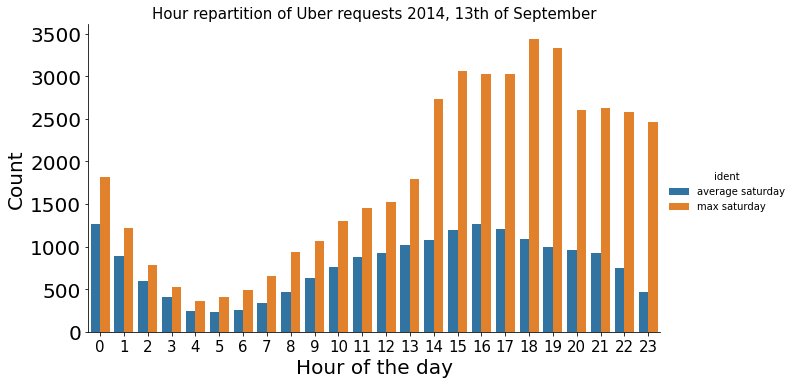

In [233]:
sns.catplot(data = df_sat_merge, x = 'hour', y = 'count', kind = 'bar', hue =  'ident', aspect = 1.8)

plt.title('Hour repartition of Uber requests 2014, 13th of September', fontsize = 15)
plt.xlabel('Hour of the day', fontdict = {'size' : 20})
plt.xticks([x for x in range(24)], fontsize = 15)
plt.ylabel('Count', fontdict={'size' : 20})
plt.yticks(fontsize = 20)

plt.show()

In comparison with an avergage saturday, people used a little more this day until 1pm, but it becomes really significan from 2pm to the end of the day. Maybe for 9/11 commemoration and/or sport event ? We could look closer to understand why this day was special but this is not the subject.

In [245]:
dbscan = DBSCAN(n_jobs=-1, eps = 0.006, min_samples = 120, metric = 'manhattan')

X = df_sat_max_value[['Lat', 'Lon']].copy()
X['predictions'] = dbscan.fit_predict(X)
fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color="predictions", mapbox_style='carto-positron')
fig.show()

# Conclusion